<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Muscle activations & muscles forces](02.01-muscle-activations-forces.ipynb) | [Contents](Index.ipynb) | [Simple ergonomics indicator](02.03-simple-ergonomic.ipynb) >

# Joint reactions

$$\text{shear:compression} = \frac{\sqrt{x^2 + y^2}}{|z|}$$

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
participants = conf.get_participants_to_process()
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
suffix = "_JointReaction_ReactionLoads*"
threshold = 0.56  # dislocation ratio (Dickerson et al.)


d = (
    pd.concat(
        [
            Analogs3d.from_sto(
                ifile, na_values=["             nan", "            -nan"]
            )
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(f"*/5_joint_reaction_force/*{suffix}")
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix=suffix)
    .reset_index()
    .query("mass != 18")
    .eval(
        "sc_ratio = sqrt(GHJ_on_glenoid_in_glenoid_fx ** 2 + GHJ_on_glenoid_in_glenoid_fy ** 2) / GHJ_on_glenoid_in_glenoid_fz.abs()"
    )
    .assign(
        index=lambda x: x["index"] / 100, ratio_sup=lambda x: x["sc_ratio"] > threshold
    )
)

d = d.drop(d.filter(like="GH", axis=1), axis=1)
d.head()

,index,filename,participant,men,height,mass,n_trial,sc_ratio,ratio_sup
0,0.00,VerCF6H2_1,verc,0,2,6,1,0.348379,False
1,0.01,VerCF6H2_1,verc,0,2,6,1,0.349915,False
2,0.02,VerCF6H2_1,verc,0,2,6,1,0.360993,False
3,0.03,VerCF6H2_1,verc,0,2,6,1,0.348304,False
4,0.04,VerCF6H2_1,verc,0,2,6,1,0.337605,False


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [5]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(d)

Initial
n. participants: 37
----------
men
0    110
1    101
----------
height
2    211
----------
mass
6     106
12    105
----------
men  mass
0    6       54
     12      56
1    6       52
     12      49
----------


In [6]:
balanced_trials = random_balanced_design(d, ["men", "mass"], random_state=RANDOM_SEED)[
    "filename"
].tolist()
d = d.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(d)

Balanced:
n. participants: 37
----------
men
0    98
1    98
----------
height
2    196
----------
mass
6     98
12    98
----------
men  mass
0    6       49
     12      49
1    6       49
     12      49
----------


## Time above dislocation ratio

In [7]:
sup_ratio = (
    d.groupby(["filename", "men", "mass"])["ratio_sup"]
    .apply(lambda x: x.sum() / x.shape[0])
    .reset_index()
)

sup_ratio.sample(5)

,filename,men,mass,ratio_sup
139,NemKH6H2_1,1,6,0.039604
113,MarHF6H2_3,0,6,0.207921
16,AleFF6H2_2,0,6,0.376238
75,GabFH12H2_2,1,12,0.000000
154,RomMH6H2_3,1,6,0.039604


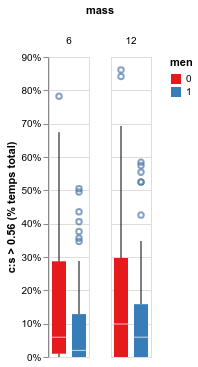

In [8]:
men_scale = alt.Scale(scheme="set1")
alt.Chart(sup_ratio).mark_boxplot().encode(
    alt.X("men:N", axis=alt.Axis(labels=False, ticks=False, domain=False), title=None),
    alt.Y("ratio_sup", axis=alt.Axis(format="%"), title="c:s > 0.56 (% temps total)"),
    alt.Color("men:N", scale=men_scale),
).facet(column="mass")

In [9]:
import spm1d

alpha = 0.05
n_iter = 10_000

spm = spm1d.stats.nonparam.anova2(
    y=sup_ratio["ratio_sup"], A=sup_ratio["men"], B=sup_ratio["mass"]
)
spmi = spm.inference(alpha=alpha, iterations=n_iter)
spmi

SnPM{F} inference list (0D)
   design      :  ANOVA2
   nEffects    :  3
   nPermUnique :  -1 permutations possible
   nPermActual :  10000
Effects:
   A     F = 5.866    p = 0.017
   B     F = 0.713    p = 0.408
   AB    F = 0.223    p = 0.638

In [10]:
for ispmi in spmi:
    if ispmi.h0reject:
        print(ispmi.effect)

Main A


<!--NAVIGATION-->
< [Muscle activations & muscles forces](02.01-muscle-activations-forces.ipynb) | [Contents](Index.ipynb) | [Simple ergonomics indicator](02.03-simple-ergonomic.ipynb) >